# Time series forecasting with sktime
Estimated time: 40 min

## Introduction

What is a time series and what can we forecast?

![](../images/ts_quiz.png)

Factors that influence ”forecastability”:
1. How much data is available.
2. How similar the future is to the past.
3. How well we understand the factors that contribute to it.
4. Whether the forecasts can affect the thing we are trying to forecast.

## Agenda
- Univariate forecasting
- Univariate with exogenous
- Multivariate
- Probabilistic forecasting
- Hierarchical forecasting

## Quickstart

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Number of shampoo sales'>)

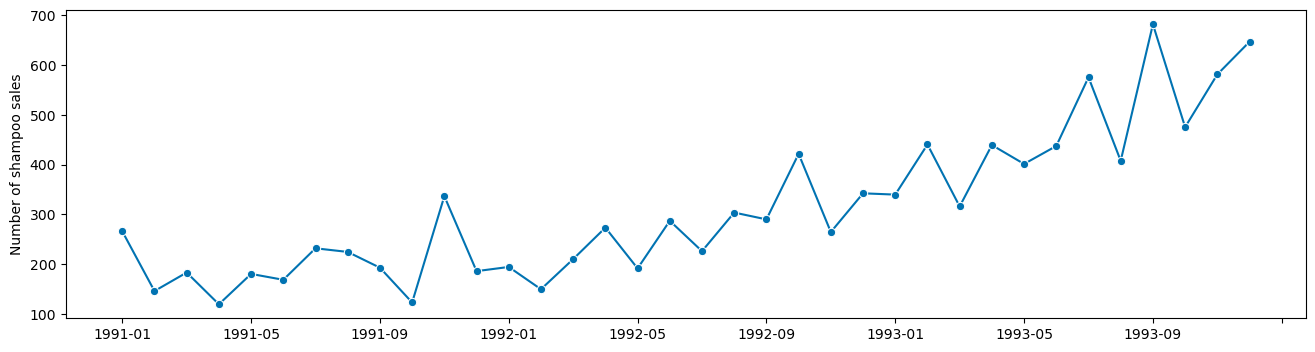

In [18]:
from sktime.datasets import load_shampoo_sales
from sktime.utils.plotting import plot_series

y = load_shampoo_sales()

plot_series(y)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Number of shampoo sales'>)

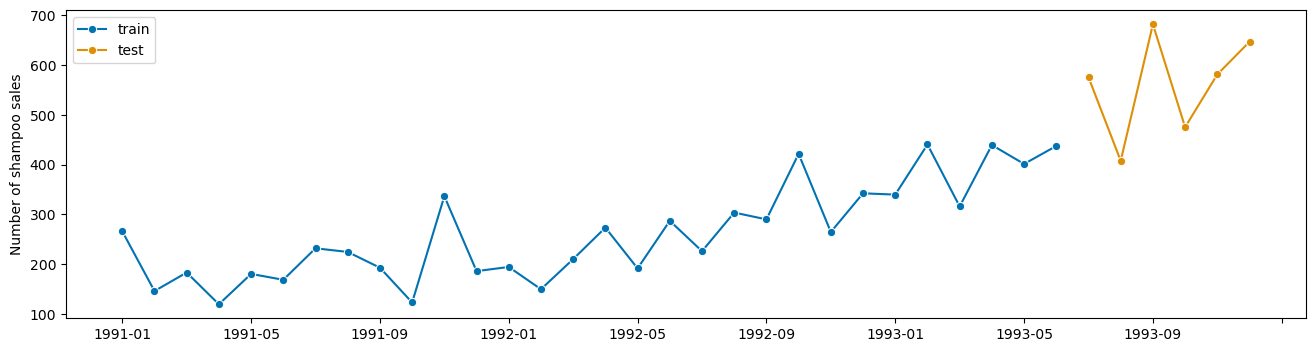

In [3]:
from sktime.forecasting.model_selection import temporal_train_test_split

y_train, y_test = temporal_train_test_split(y=y, test_size=6)
plot_series(y_train, y_test, labels=["train", "test"])

09:14:06 - cmdstanpy - INFO - Chain [1] start processing
09:14:07 - cmdstanpy - INFO - Chain [1] done processing


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Number of shampoo sales'>)

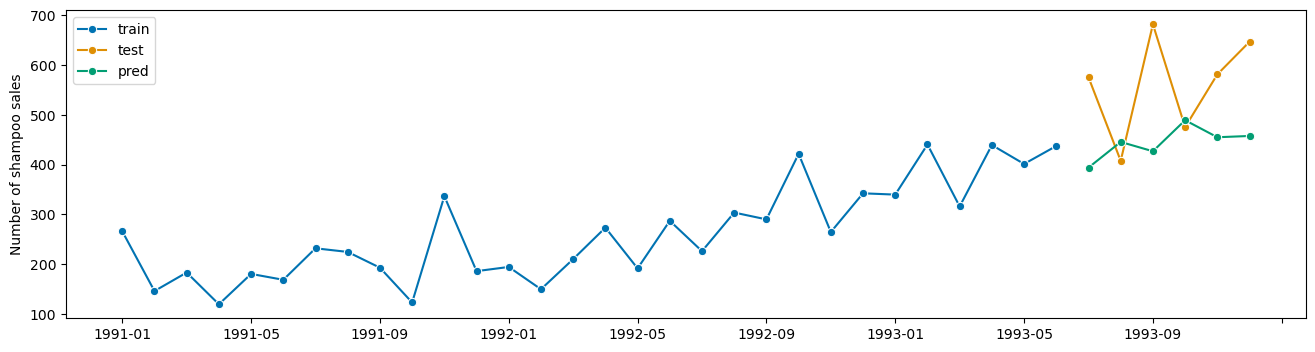

In [4]:
from sktime.forecasting.fbprophet import Prophet

# 1) Define the model
forecaster = Prophet()

# 2) Fit on train data
forecaster.fit(y_train) 

# 3) Use fitted model to predict for a certain forecast horizon (fh)
fh = [1, 2, 3, 4, 5, 6]
y_pred = forecaster.predict(fh)  

plot_series(y_train, y_test, y_pred, labels=["train", "test", "pred"])

In [5]:
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

smape = MeanAbsolutePercentageError(symmetric=True)

print(f"Prophet - sMAPE error: {smape(y_test, y_pred):.1%}")

Prophet - sMAPE error: 25.7%


## Univariate forecasting

### Other statistical (classical) forecasting methods

Let's try to improve our forecasting performance by using other stats-based method.

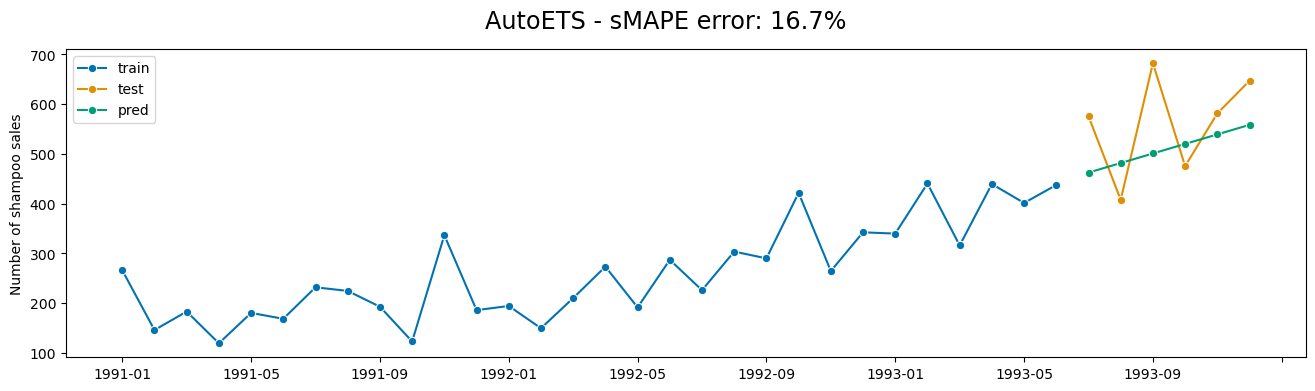

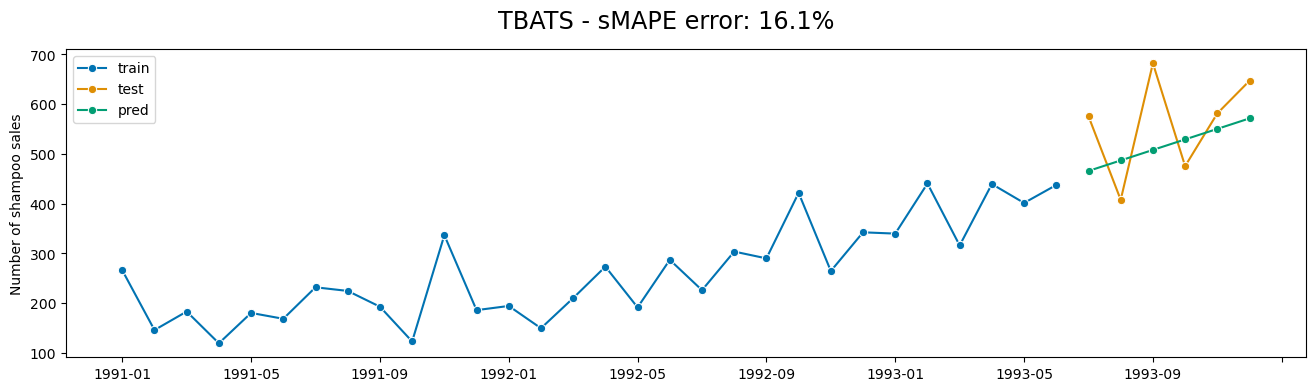

In [12]:
from sktime.forecasting.tbats import TBATS
from sktime.forecasting.ets import AutoETS

forecasters = [AutoETS(auto=True), TBATS(sp=12)]

for forecaster in forecasters:
    y_pred = forecaster.fit_predict(y=y_train, fh=fh)
    title = f"{str(forecaster).split('(')[0]} - sMAPE error: {smape(y_test, y_pred):.1%}"
    plot_series(y_train, y_test, y_pred, labels=["train", "test", "pred"], title=title)

### Forecasting with ML algorithms

We can use sklearn regressors (or a library like lightgbm) to forecast time series. 

But we need to transform our data into a tabular format first, with a table of features and a target columns.

![](../images/tabularization.png)

We can use autocorrelation and partial autocorrelation plots to help us select the window length for our tabularization.

(<Figure size 1200x800 with 3 Axes>,
 array([<Axes: ylabel='Number of shampoo sales'>,
        <Axes: title={'center': 'Autocorrelation'}>,
        <Axes: title={'center': 'Partial Autocorrelation'}>], dtype=object))

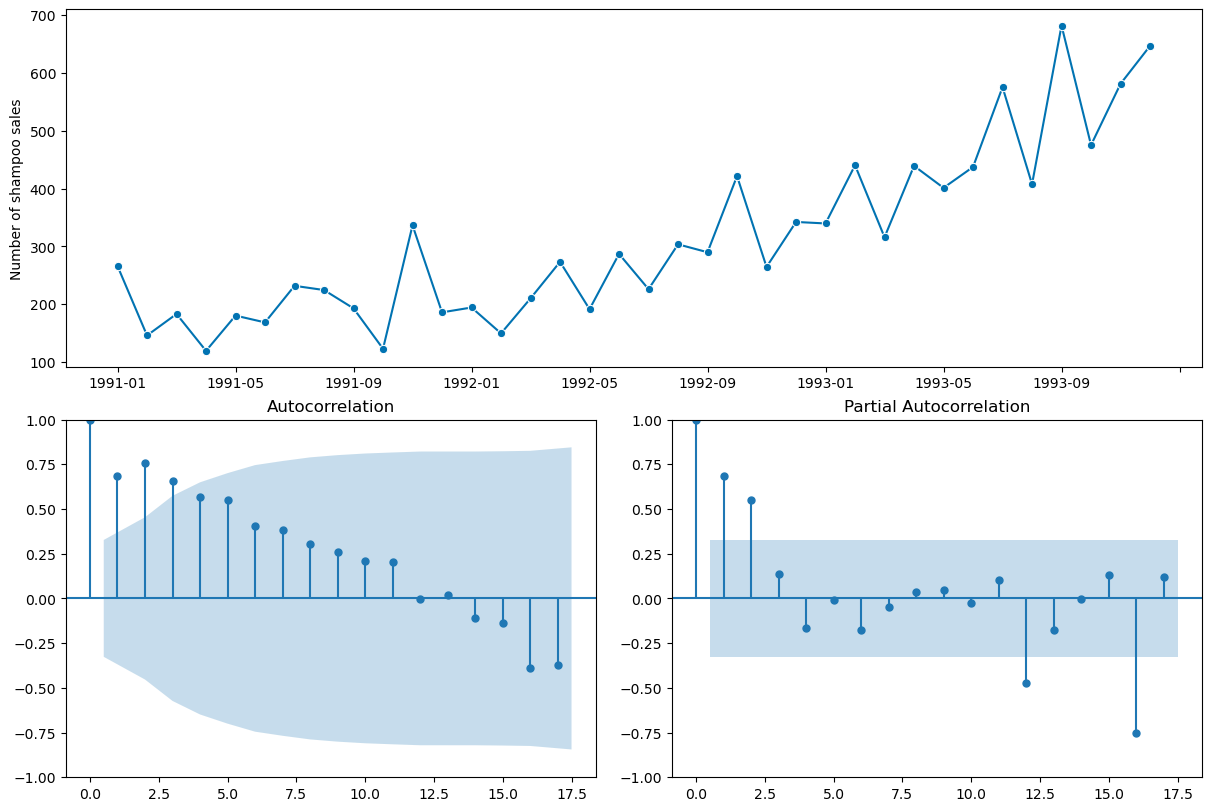

In [32]:
from sktime.utils.plotting import plot_correlations

plot_correlations(y, lags=17)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Number of shampoo sales'>)

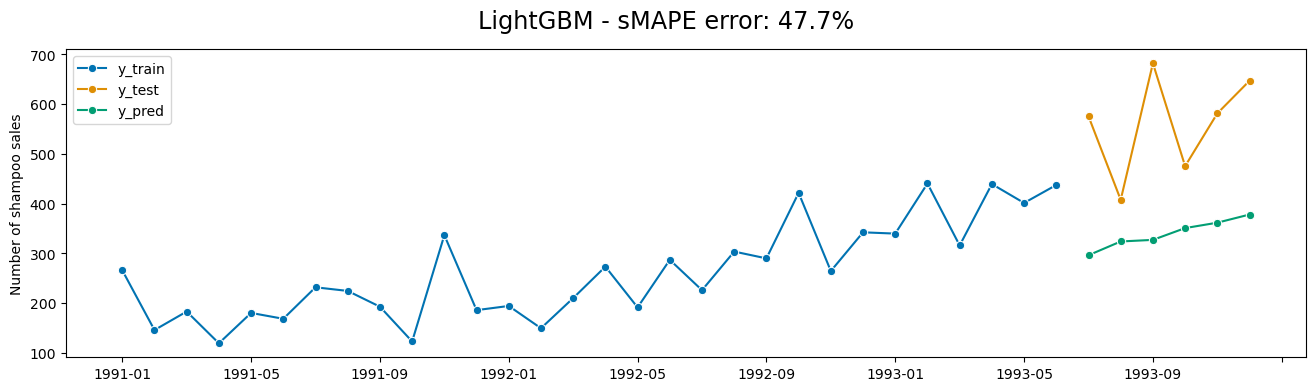

In [38]:
import lightgbm as lgb
from sktime.forecasting.compose import make_reduction

regressor = regressor = lgb.LGBMRegressor()
forecaster = make_reduction(regressor, strategy="direct", window_length=16)
y_pred = forecaster.fit_predict(y=y_train, fh=fh)
title = f"LightGBM - sMAPE error: {smape(y_test, y_pred):.1%}"
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], title=title)

Why the bad performance? Gradient boosting trees cannot extrapolate, so hey will not forecast values they have not seen.

A simple way to address this is to apply a first-differencing transformation to the data before tabularization.

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Number of shampoo sales'>)

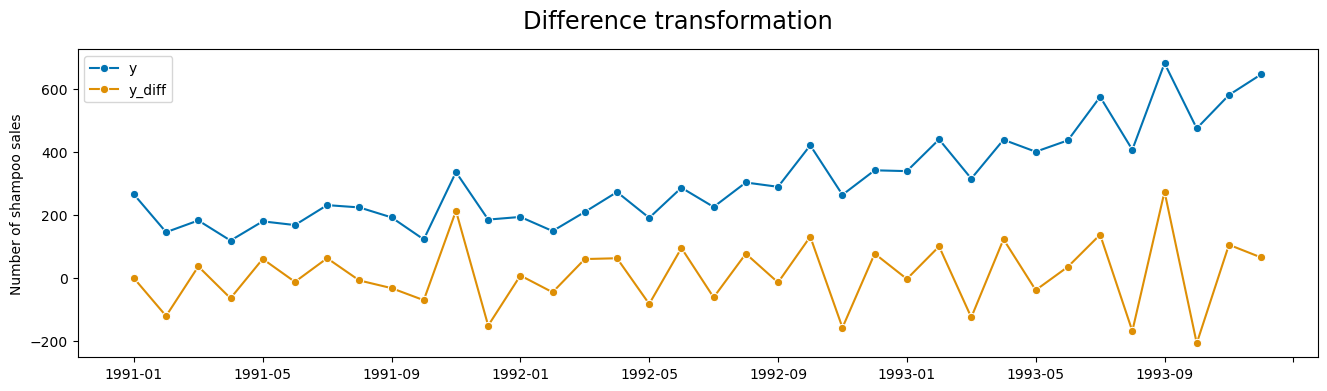

In [44]:
from sktime.transformations.series.difference import Differencer

transformer = Differencer(lags=1)
y_transform = transformer.fit_transform(y)
plot_series(y, y_transform, labels=["y", "y_diff"], title="Difference transformation")

/usr/local/Caskroom/miniforge/base/envs/pydata_sktime/lib/python3.9/site-packages/sktime/forecasting/compose/_pipeline.py:91: UserWarning: in TransformedTargetForecaster, found steps of length 1, this will result in the same behaviour as not wrapping the single step in a pipeline. Consider not wrapping steps in TransformedTargetForecaster as it is redundant.
  warn(msg)


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Number of shampoo sales'>)

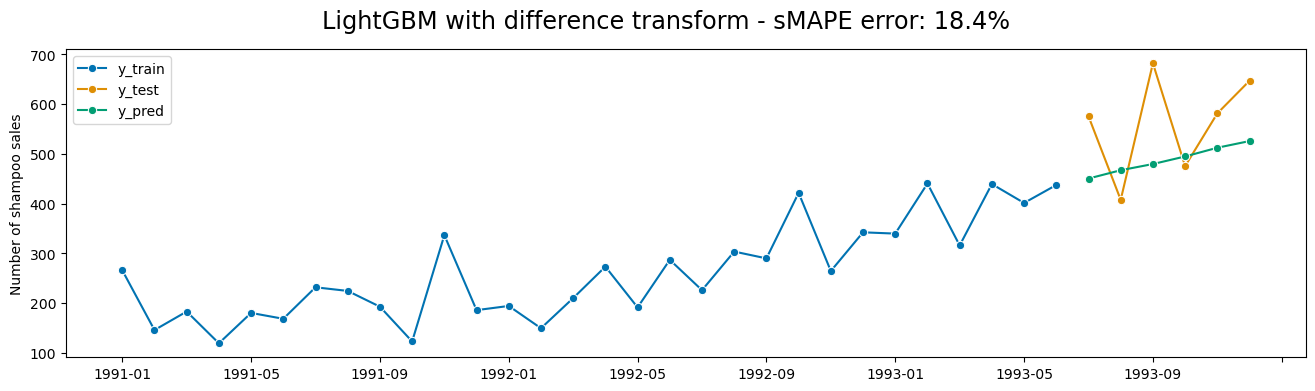

In [67]:
regressor = regressor = lgb.LGBMRegressor()
forecaster = make_reduction(regressor, strategy="direct", window_length=15)
forecaster_with_differencer = Differencer(lags=1) * forecaster
y_pred = forecaster_with_differencer.fit_predict(y=y_train, fh=fh)
title = f"LightGBM with difference transform - sMAPE error: {smape(y_test, y_pred):.1%}"
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], title=title)

Check out all other sktime forecasting algorithms [here](https://www.sktime.net/en/latest/api_reference/forecasting.html).

### 

## Univariate with exogenous

## Multivariate

## Probabilistic forecasting

## Hierarchical forecasting